<h1>Traffic signs detection using CNN</h1>

In [27]:
import os
import torch
from torch.autograd import Variable
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

<h4>1. Data Preprocessing </h4>

In [32]:
#DIR = {'left turns':0,'traffic_light':1,'u_turn':2,'right_turns':3,'stop':4}
DIR = {'left':0,'right':1,'uturn':2,'stop':3}
Outputs = {'0':'Left Turn','1':'Right Light','2':'U turn','3':'Stop'}
SUB_DIR = ['images', 'augmentedImages']
image_name = []
image_tag = []
for key,value in DIR.items():
    #for sd in SUB_DIR:
    for img in os.listdir('data/'+key):
        if img != '.DS_Store':
            image_name.append(key+'/'+img)
            image_tag.append(value)
df = pd.DataFrame({'Name':image_name,'Target':image_tag})
df.to_csv('ImageDataset.csv',index=None)
Image_Train, Image_Test, Label_Train, Label_Test = train_test_split(image_name,image_tag,test_size = 0.3)

<h4>Custom Dataset preparation</h4>

In [33]:
class MyCustomDataset(Dataset):
    def __init__(self,imgs,targets):
        # stuff
        self.imgpath = imgs
        self.label = targets
    def __getitem__(self, index):
        img = cv2.imread('data/'+self.imgpath[index],0)#.transpose(2,0,1)
        img = cv2.resize(img, (224,224))
        img = torch.from_numpy(img).type(torch.FloatTensor)
        img = torch.unsqueeze(img,0)
        # stuff
        label = self.label[index]
        #print(label)
        return (img, label)

    def __len__(self):
        return len(self.imgpath) # of how many examples(images?) you have

In [34]:
dataset = MyCustomDataset(Image_Train,Label_Train)
train_loader = DataLoader(dataset,
                          batch_size=10,
                          shuffle=True,
                         )
test_dataset = MyCustomDataset(Image_Test,Label_Test)
test_loader = DataLoader(test_dataset,
                          batch_size=10,
                          shuffle=True,
                         )

<h3>CNN model</h3>

In [35]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=3)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3)
        self.conv3 = nn.Conv2d(32,16,kernel_size=3)
        self.conv4 = nn.Conv2d(16,8,kernel_size=3)
        self.conv5 = nn.Conv2d(8,4,kernel_size=3)
        self.fc = nn.Linear(100,5)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
    def forward(self,img):
        img_size = img.size(0)
        c1 = F.relu(self.maxpool(self.conv1(img)))
        c2 = F.relu(self.maxpool(self.conv2(c1)))
        c3 = F.relu(self.maxpool(self.conv3(c2)))
        c4 = F.relu(self.maxpool(self.conv4(c3)))
        c5 = F.relu(self.maxpool(self.conv5(c4)))
        c5 = c5.view(img_size, -1)
        c6 = self.fc(c5)
        return c6

In [36]:
model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

<h4>Train and Test </h4>

In [37]:
def Train(epoch):
    model.train()
    for index,(img,target) in enumerate(train_loader):
        img,target = Variable(img),Variable(target)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if index % 10 == 0:
            print(output.data.max(1, keepdim=True)[1],target)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, index * len(img), len(train_loader.dataset),
                100. * index / len(train_loader), loss.data[0]))

def Test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for e in range(1,30):
    Train(e)
    Test()


(tensor([[ 0],
        [ 2],
        [ 4],
        [ 4],
        [ 0],
        [ 1],
        [ 1],
        [ 0],
        [ 0],
        [ 3]]), tensor([ 0,  2,  4,  4,  0,  1,  1,  0,  0,  3]))
Train Epoch: 1 [0/514 (0%)]	Loss: 0.000207


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


(tensor([[ 1],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 2],
        [ 0],
        [ 0]]), tensor([ 1,  0,  0,  0,  0,  1,  0,  2,  0,  0]))
Train Epoch: 1 [100/514 (19%)]	Loss: 0.000018
(tensor([[ 1],
        [ 1],
        [ 4],
        [ 4],
        [ 1],
        [ 0],
        [ 4],
        [ 4],
        [ 2],
        [ 1]]), tensor([ 1,  1,  4,  4,  1,  0,  4,  4,  2,  1]))
Train Epoch: 1 [200/514 (38%)]	Loss: 0.001643
(tensor([[ 2],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 4],
        [ 0],
        [ 0],
        [ 0],
        [ 4]]), tensor([ 2,  0,  0,  1,  0,  4,  0,  0,  0,  4]))
Train Epoch: 1 [300/514 (58%)]	Loss: 0.001642
(tensor([[ 0],
        [ 4],
        [ 0],
        [ 2],
        [ 0],
        [ 1],
        [ 4],
        [ 0],
        [ 0],
        [ 0]]), tensor([ 0,  4,  0,  2,  0,  1,  4,  0,  0,  0]))
Train Epoch: 1 [400/514 (77%)]	Loss: 0.002027
(tensor([[ 0],
        [ 0],
        [ 2],
 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: -25.0403, Accuracy: 201/221 (90%)

(tensor([[ 0],
        [ 0],
        [ 1],
        [ 1],
        [ 2],
        [ 0],
        [ 0],
        [ 2],
        [ 0],
        [ 4]]), tensor([ 0,  0,  1,  1,  2,  0,  0,  2,  0,  4]))
Train Epoch: 2 [0/514 (0%)]	Loss: 0.001130
(tensor([[ 2],
        [ 0],
        [ 2],
        [ 0],
        [ 4],
        [ 3],
        [ 0],
        [ 0],
        [ 1],
        [ 2]]), tensor([ 2,  0,  2,  0,  4,  3,  0,  0,  1,  2]))
Train Epoch: 2 [100/514 (19%)]	Loss: 0.000352
(tensor([[ 0],
        [ 0],
        [ 0],
        [ 4],
        [ 0],
        [ 0],
        [ 0],
        [ 2],
        [ 2],
        [ 4]]), tensor([ 0,  0,  0,  4,  0,  0,  0,  2,  2,  4]))
Train Epoch: 2 [200/514 (38%)]	Loss: 0.001151
(tensor([[ 4],
        [ 0],
        [ 3],
        [ 1],
        [ 0],
        [ 0],
        [ 2],
        [ 0],
        [ 1],
        [ 4]]), tensor([ 4,  0,  3,  1,  0,  0,  2,  0,  1,  4]))
Train Epoch: 2 [300/514 (58%)]	Lo

(tensor([[ 0],
        [ 0],
        [ 0],
        [ 4],
        [ 0],
        [ 4],
        [ 1],
        [ 0],
        [ 1],
        [ 0]]), tensor([ 0,  0,  0,  4,  0,  4,  1,  0,  1,  0]))
Train Epoch: 7 [300/514 (58%)]	Loss: 0.000034
(tensor([[ 0],
        [ 4],
        [ 0],
        [ 4],
        [ 0],
        [ 3],
        [ 1],
        [ 0],
        [ 0],
        [ 0]]), tensor([ 0,  4,  0,  4,  0,  3,  1,  0,  0,  0]))
Train Epoch: 7 [400/514 (77%)]	Loss: 0.000143
(tensor([[ 2],
        [ 2],
        [ 4],
        [ 0],
        [ 2],
        [ 0],
        [ 0],
        [ 2],
        [ 0],
        [ 4]]), tensor([ 2,  2,  4,  0,  2,  0,  0,  2,  0,  4]))
Train Epoch: 7 [500/514 (96%)]	Loss: 0.000127

Test set: Average loss: -27.3128, Accuracy: 200/221 (90%)

(tensor([[ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 1]]), tensor([ 0,  0,  1,  0,  0,  0,  0,  0,  0,  1]))
Train Epoch: 8 [0/514 (0%)]	Lo

(tensor([[ 0],
        [ 0],
        [ 3],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 0],
        [ 0]]), tensor([ 0,  0,  3,  0,  0,  0,  1,  0,  0,  0]))
Train Epoch: 13 [0/514 (0%)]	Loss: 0.000054
(tensor([[ 0],
        [ 2],
        [ 1],
        [ 0],
        [ 0],
        [ 0],
        [ 2],
        [ 0],
        [ 1],
        [ 3]]), tensor([ 0,  2,  1,  0,  0,  0,  2,  0,  1,  3]))
Train Epoch: 13 [100/514 (19%)]	Loss: 0.001529
(tensor([[ 1],
        [ 0],
        [ 4],
        [ 0],
        [ 2],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0]]), tensor([ 1,  0,  4,  0,  2,  0,  0,  0,  0,  0]))
Train Epoch: 13 [200/514 (38%)]	Loss: 0.000219
(tensor([[ 3],
        [ 4],
        [ 4],
        [ 1],
        [ 4],
        [ 2],
        [ 4],
        [ 2],
        [ 0],
        [ 0]]), tensor([ 3,  4,  4,  1,  4,  2,  4,  2,  0,  0]))
Train Epoch: 13 [300/514 (58%)]	Loss: 0.000001
(tensor([[ 0],
        [ 4],
        [ 2],


(tensor([[ 0],
        [ 4],
        [ 2],
        [ 1],
        [ 0],
        [ 3],
        [ 0],
        [ 2],
        [ 1],
        [ 4]]), tensor([ 0,  4,  2,  1,  0,  3,  0,  2,  1,  4]))
Train Epoch: 18 [300/514 (58%)]	Loss: 0.000600
(tensor([[ 0],
        [ 0],
        [ 4],
        [ 2],
        [ 4],
        [ 4],
        [ 0],
        [ 0],
        [ 1],
        [ 4]]), tensor([ 0,  0,  4,  2,  4,  4,  0,  0,  1,  4]))
Train Epoch: 18 [400/514 (77%)]	Loss: 0.000019
(tensor([[ 4],
        [ 0],
        [ 0],
        [ 4],
        [ 2],
        [ 2],
        [ 2],
        [ 0],
        [ 0],
        [ 0]]), tensor([ 4,  0,  0,  4,  2,  2,  2,  0,  0,  0]))
Train Epoch: 18 [500/514 (96%)]	Loss: 0.000498

Test set: Average loss: -29.7885, Accuracy: 200/221 (90%)

(tensor([[ 0],
        [ 0],
        [ 0],
        [ 4],
        [ 4],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0]]), tensor([ 0,  0,  0,  4,  4,  0,  0,  0,  1,  0]))
Train Epoch: 19 [0/514 (0%)


Test set: Average loss: -30.6563, Accuracy: 201/221 (90%)

(tensor([[ 0],
        [ 0],
        [ 2],
        [ 2],
        [ 0],
        [ 1],
        [ 0],
        [ 1],
        [ 0],
        [ 0]]), tensor([ 0,  0,  2,  2,  0,  1,  0,  1,  0,  0]))
Train Epoch: 24 [0/514 (0%)]	Loss: 0.000292
(tensor([[ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 0],
        [ 2],
        [ 0],
        [ 0]]), tensor([ 0,  0,  0,  0,  1,  0,  0,  2,  0,  0]))
Train Epoch: 24 [100/514 (19%)]	Loss: 0.000233
(tensor([[ 0],
        [ 0],
        [ 3],
        [ 4],
        [ 0],
        [ 4],
        [ 1],
        [ 2],
        [ 2],
        [ 1]]), tensor([ 0,  0,  3,  4,  0,  4,  1,  2,  2,  1]))
Train Epoch: 24 [200/514 (38%)]	Loss: 0.000355
(tensor([[ 0],
        [ 3],
        [ 1],
        [ 2],
        [ 2],
        [ 4],
        [ 2],
        [ 0],
        [ 4],
        [ 2]]), tensor([ 0,  3,  1,  2,  2,  4,  2,  0,  4,  2]))
Train Epoch: 24 [300/514 (58%)

Action:  Left Turn


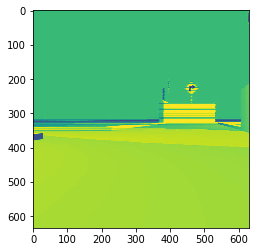

In [44]:
impath = '/home/eindhan/catkin_workspace/src/hackathon/data/right/Aug_default_gzclient_camera(1)-2018-05-19T11_45_14.184884.jpg_auto'
img = cv2.imread(impath,0)
img = cv2.resize(img, (224,224))
img = torch.from_numpy(img).type(torch.FloatTensor)
imgs = torch.unsqueeze(img,0)
imgs = torch.unsqueeze(imgs,0)
out = model(imgs).data.max(1, keepdim=True)[1][0][0].data.cpu().numpy()
print 'Action: ',Outputs[str(out)]
plt.imshow(cv2.imread(impath,0))

In [40]:
#torch.save(model, './CNN.pt')
PATH='./CNN_v3.pt'
torch.save(model.state_dict(), PATH)


In [19]:
def cnnmodel():
    #the_model = torch.load('./CNN')
    the_model = TheModelClass(*args, **kwargs)
    the_model.load_state_dict(torch.load(PATH))
    return the_model

In [16]:
the_model = MyCNN()
the_model.load_state_dict(torch.load(PATH))
the_model.eval()
out = the_model(imgs).data.max(1, keepdim=True)[1][0][0].data.cpu().numpy()
print 'Action: ',Outputs[str(out)]

Action:  Right Turns
